# 0. 라이브러리 import

In [1]:
pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import re
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from transformers import BertTokenizerFast
from transformers import TFBertForSequenceClassification
from transformers import TextClassificationPipeline
import wandb
from wandb.integration.keras import WandbCallback
import tensorflow_addons as tfa
from tqdm import tqdm
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices() )

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9021790087185416531
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11705909248
locality {
  bus_id: 1
  links {
  }
}
incarnation: 900724482708366852
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


# 1. 데이터 확인

In [4]:
train_data_path ="~/aiffel/dktc/data/train.csv"
train_data = pd.read_csv(train_data_path)
train_data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [5]:
common_data_path ="~/aiffel/aiffel/dlthon/AIFFEL_DLthon/file/sampled_dataset.csv"
common_data = pd.read_csv(common_data_path)
common_data = common_data[:1000]
common_data.head()

,text,label
0,닌 된다 오카방 보니까\n면접\n열폭하는\n바보 그자체야\n인간들 만음\n난 걍 불...,일반 대화
1,그치 하지만 오빠가 아니면 내가 그오빠들을 따로 만날일은 없지\n억울하면 너도 가지...,일반 대화
2,오 생각보다 깔끔?\n나야 #@이름# ㅎ\n풉 ㅋ #@이름# 멋지다잉~\n더\n#@...,일반 대화
3,차라리 아까 20시간 간다\nㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ...,일반 대화
4,입원하나요?!\n조용하네 아직 기다리는중요ㅎㅎ\n역시 일찍일어난새가 먹이를먹네요\n...,일반 대화


In [6]:
common_data.rename(columns={'text': 'conversation', 'label': 'class'}, inplace=True)
train_data = pd.concat([train_data, common_data], ignore_index=True)
train_data = train_data.sample(frac=1).reset_index(drop=True)
train_data.head()

,idx,class,conversation
0,3362.0,직장 내 괴롭힘 대화,그 이야기 들었어??\n뭔데뭔데 무슨일이야?\n아니 인사팀에 있는 박대리가 부장님 ...
1,329.0,직장 내 괴롭힘 대화,빨리빨리 일 처리 안해?\n 죄송합니다\n 김대리 짤리고 싶어?\n죄송합니다 빨리 ...
2,1118.0,갈취 대화,어이 너 입고 있는 코트 멋있다\n저요?\n그래. 너 말고 여기 또 누구 있나\n코...
3,2241.0,기타 괴롭힘 대화,야 너 어제 내 대신 동아리방 청소하랬지\n아 맞다.\n맞고싶냐?오늘 당장해라\n알...
4,2471.0,갈취 대화,학생!\n왜요?\n내가 집에 갈 차비가 없어서 말이야.\n그런데요?\n네가 돈 좀 ...


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4950 entries, 0 to 4949
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   idx           3950 non-null   float64
 1   class         4950 non-null   object 
 2   conversation  4950 non-null   object 
dtypes: float64(1), object(2)
memory usage: 116.1+ KB
None


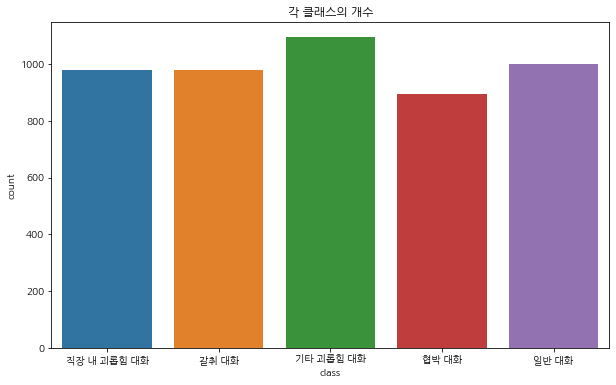

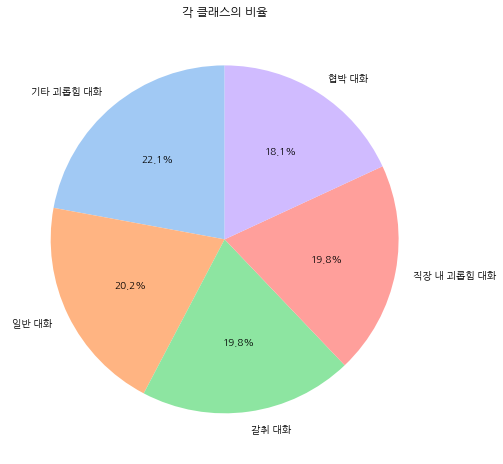

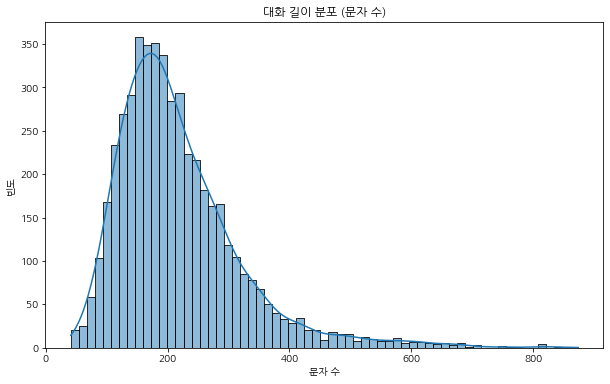

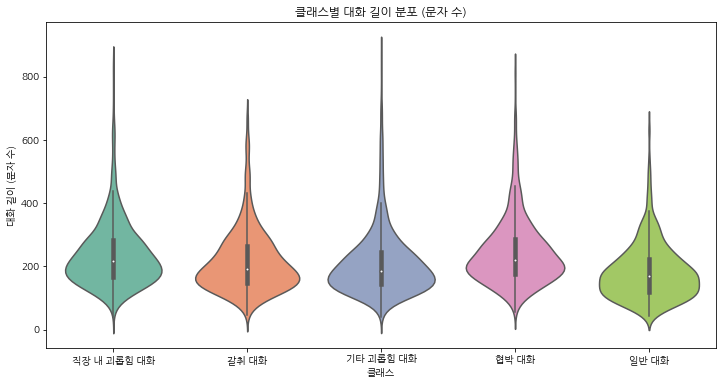

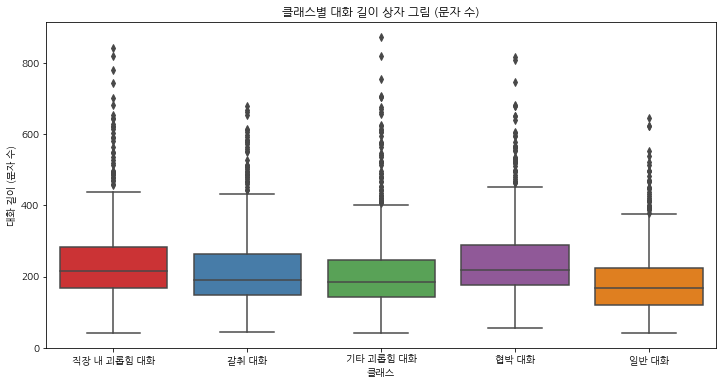

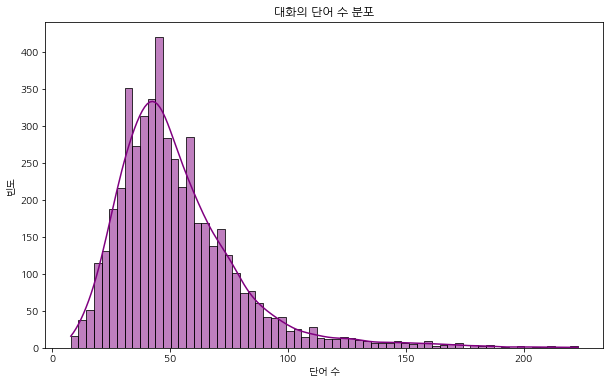

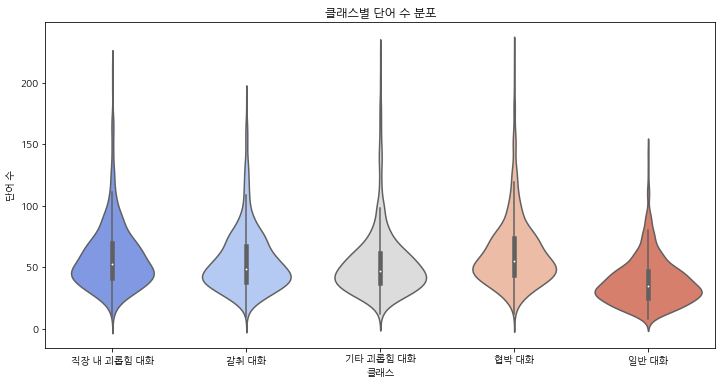

In [7]:
# 한글 폰트 설정 (여기서는 'NanumGothic' 폰트를 사용)
plt.rcParams['font.family'] = 'NanumGothic'

# 데이터 기본 정보 확인
print("Train Data Info:")
print(train_data.info())  # 데이터 타입, 결측치 확인

# 1. 'class' 컬럼의 분포 확인
plt.figure(figsize=(10, 6))
sns.countplot(x='class', data=train_data)
plt.title('각 클래스의 개수')
plt.show()

# 2. 'class' 컬럼의 비율을 Pie Chart로 시각화
plt.figure(figsize=(8, 8))
train_data['class'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('각 클래스의 비율')
plt.ylabel('')  # Y-label 제거
plt.show()

# 3. 'conversation' 텍스트의 길이 분포 확인 (각 문장의 문자 수)
train_data['text_length'] = train_data['conversation'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(train_data['text_length'], kde=True)
plt.title('대화 길이 분포 (문자 수)')
plt.xlabel('문자 수')
plt.ylabel('빈도')
plt.show()

# 4. 'class'별로 'conversation' 길이 분포 확인 (Violin Plot)
plt.figure(figsize=(12, 6))
sns.violinplot(x='class', y='text_length', data=train_data, palette='Set2')
plt.title('클래스별 대화 길이 분포 (문자 수)')
plt.xlabel('클래스')
plt.ylabel('대화 길이 (문자 수)')
plt.show()

# 5. 'class'별로 'conversation' 길이 상자 그림(Boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(x='class', y='text_length', data=train_data, palette='Set1')
plt.title('클래스별 대화 길이 상자 그림 (문자 수)')
plt.xlabel('클래스')
plt.ylabel('대화 길이 (문자 수)')
plt.show()

# 6. 'class'별로 대화 내용의 단어 수 분포 확인
train_data['word_count'] = train_data['conversation'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(train_data['word_count'], kde=True, color='purple')
plt.title('대화의 단어 수 분포')
plt.xlabel('단어 수')
plt.ylabel('빈도')
plt.show()

# 7. 'class'별로 단어 수 분포 확인 (Violin Plot)
plt.figure(figsize=(12, 6))
sns.violinplot(x='class', y='word_count', data=train_data, palette='coolwarm')
plt.title('클래스별 단어 수 분포')
plt.xlabel('클래스')
plt.ylabel('단어 수')
plt.show()

In [8]:
train_data.isnull().sum()

idx             1000
class              0
conversation       0
text_length        0
word_count         0
dtype: int64

# 2. 라벨 인코딩 & 데이터 정제

라벨 인코딩

In [9]:
CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화']

label_size = len(CLASS_NAMES)

encoder = LabelEncoder()
encoder.fit(CLASS_NAMES)

train_data['class'] = encoder.transform(train_data['class'])
train_data.head()

,idx,class,conversation,text_length,word_count
0,3362.0,3,그 이야기 들었어??\n뭔데뭔데 무슨일이야?\n아니 인사팀에 있는 박대리가 부장님 ...,209,46
1,329.0,3,빨리빨리 일 처리 안해?\n 죄송합니다\n 김대리 짤리고 싶어?\n죄송합니다 빨리 ...,147,31
2,1118.0,0,어이 너 입고 있는 코트 멋있다\n저요?\n그래. 너 말고 여기 또 누구 있나\n코...,141,41
3,2241.0,1,야 너 어제 내 대신 동아리방 청소하랬지\n아 맞다.\n맞고싶냐?오늘 당장해라\n알...,116,29
4,2471.0,0,학생!\n왜요?\n내가 집에 갈 차비가 없어서 말이야.\n그런데요?\n네가 돈 좀 ...,212,60


In [10]:
# 데이터 정제 함수
def preprocess_sentence(sentence):

    # 앞뒤 공백 제거
    sentence = sentence.strip()
    # 한글, 영어, 숫자, 구두점 외 제거
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9.,!? ]", " ", sentence)
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 다중 공백을 단일 공백으로
    sentence = re.sub(r"\s+", " ", sentence)
    
    # ㅋㅋ, ㅎㅎ, ㅠㅠ 등을 정규화
    sentence = re.sub(r'ㅋ{2,}', 'ㅋㅋ', sentence)  # 연속된 ㅋ를 ㅋㅋ로 통일
    sentence = re.sub(r'ㅎ{2,}', 'ㅎㅎ', sentence)  # 연속된 ㅎ를 ㅎㅎ로 통일
    sentence = re.sub(r'ㅠ{2,}', 'ㅠㅠ', sentence)  # 연속된 ㅠ를 ㅠㅠ로 통일

    return sentence

In [11]:
# 데이터 정제
clean_data=[]

for x in train_data['conversation']:
    clean_data.append(preprocess_sentence(x))
    
len(clean_data)

4950

In [12]:
# 정제된 데이터 conversation에 저장
train_data['conversation'] = clean_data

# 3. 데이터셋 분리

In [13]:
# input, target 리스트화
train_texts = train_data['conversation'].to_list() # Features (not-tokenized yet)
train_labels = train_data["class"].to_list() # Labels

In [14]:
x_train, x_test, y_train, y_test = train_test_split(train_texts, train_labels, test_size=0.25, random_state=14561)

print("x_train lenght :", len(x_train))
print("x_test lenght :", len(x_test))
print("y_train lenght :", len(y_train))
print("y_test lenght :", len(y_test))

x_train lenght : 3712
x_test lenght : 1238
y_train lenght : 3712
y_test lenght : 1238


In [15]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=14561)

print("x_train lenght :", len(x_train))
print("x_val lenght :", len(x_val))
print("y_train lenght :", len(y_train))
print("y_val lenght :", len(y_val))

x_train lenght : 2598
x_val lenght : 1114
y_train lenght : 2598
y_val lenght : 1114


# 4. 사전 훈련된 모델의 토크나이저 load

In [16]:
HUGGINGFACE_MODEL_PATH = "klue/bert-base"

klue_bert_tokenizer = BertTokenizerFast.from_pretrained(HUGGINGFACE_MODEL_PATH)

# 5. 토큰화 & 숫자 시퀀스로 변환

In [17]:
# Tokenizing
train_encodings = klue_bert_tokenizer(x_train, truncation=True, padding=True)
val_encodings = klue_bert_tokenizer(x_val, truncation=True, padding=True)
test_encodings = klue_bert_tokenizer(x_test, truncation=True, padding=True)

# 6. 훈련에 사용될 dataset 생성

데이터셋 객체 생성

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((
        dict(train_encodings),
        y_train
))

In [19]:
val_dataset = tf.data.Dataset.from_tensor_slices((
        dict(val_encodings),
        y_val
))

# 7. 사전 훈련된 모델 load

In [20]:
num_labels = len(encoder.classes_)
klue_bert_model = TFBertForSequenceClassification.from_pretrained(HUGGINGFACE_MODEL_PATH, num_labels=num_labels, from_pt=True)

'''optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
klue_bert_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])'''

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


"optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)\nloss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)\nklue_bert_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])"

In [21]:
# Electra 층 동결
klue_bert_model.bert.trainable = False

In [22]:
klue_bert_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  110617344 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  3845      
Total params: 110,621,189
Trainable params: 3,845
Non-trainable params: 110,617,344
_________________________________________________________________


# 8. wandb -> 최적의 하이퍼파라미터값 찾기

In [23]:
wandb.login(key = "d5b43035f76ce84b3b50ba2ac5cd415f67f54b08")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Currently logged in as: vieisi8 (vieisi8-123). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

In [24]:
# 하이퍼파라미터 종류 정의
# 여기선 learning_rate, epoch만 설정
sweep_config = {
    "name": "klue_bert",
    "metric": {"name": "val_custom_f1score", "goal": "maximize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "min" : 1e-5,
            "max" : 9e-5
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 10,
            "max" : 15
            }
                    
        }
    }

In [25]:
def create_model(HUGGINGFACE_MODEL_PATH):
    num_labels = len(encoder.classes_)
    model = TFBertForSequenceClassification.from_pretrained(HUGGINGFACE_MODEL_PATH, num_labels=num_labels, from_pt=True)
    model.bert.trainable = False
    
    return model

In [26]:
def save_model(model, tokenizer, MODEL_NAME, MODEL_SAVE_PATH):
    # label을 숫자형태로 encoding 진행함
    # decoding 숫자 -> label 변환
    try:
        
        id2labels = model.config.id2label
        model.config.id2label = {id : encoder.inverse_transform([int(re.sub('LABEL_', '', label))])[0]  for id, label in id2labels.items()}

        label2ids = model.config.label2id
        model.config.label2id = {encoder.inverse_transform([int(re.sub('LABEL_', '', label))])[0] : id   for id, label in id2labels.items()}
        
    except Exception as e:
        print("label이 이미 decoding 되있습니다!")

    if os.path.exists(MODEL_SAVE_PATH):
        print(f"{MODEL_SAVE_PATH} -- Folder already exists \n")
    else:
        os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
        print(f"{MODEL_SAVE_PATH} -- Folder create complete \n")

    # save tokenizer, model
    model.save_pretrained(MODEL_SAVE_PATH, save_format='tf')
    tokenizer.save_pretrained(MODEL_SAVE_PATH)

In [27]:
def f1_score_calculation(data, label, text_classifier):
    y_pred = []

    for text in tqdm(data, desc="predictive processing", total=len(data)):
        # predict
        preds_list = text_classifier(text)[0]

        sorted_preds_list = sorted(preds_list, key=lambda x: x['score'], reverse=True)
        preds_list = sorted_preds_list[0] 

        label_value = preds_list['label']
        y_pred.append(label_value)
        
    # label decoding 숫자 -> label 변환
    label = encoder.inverse_transform(label)
    
    # F1 점수 계산
    f1 = f1_score(label, y_pred, average='macro')  # macro는 클래스 크기에 상관없이 모든 클래스를 같은 비중으로 다룸
    
    return f1

In [28]:
# tfa.metrics.F1Score을 사용하되
# y_true, y_pred shape을 통일 하기 위해 정의함
class CustomF1Score(tf.keras.metrics.Metric):
    def __init__(self, num_classes, **kwargs):
        super(CustomF1Score, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.f1 = tfa.metrics.F1Score(num_classes=num_classes, average='macro')

    def update_state(self, y_true, y_pred, sample_weight=None):
        
        y_true_one_hot = tf.one_hot(y_true, depth=self.num_classes) # shape=(None, 1, 5)
        # 차원 축소하여 (None, 5)로 변경
        y_true_one_hot = tf.squeeze(y_true_one_hot, axis=1)

        
        # 로짓을 소프트맥스로 변환하여 클래스 확률로 변환
        y_pred = tf.nn.softmax(y_pred) # shape=(None, 5)
        
        return self.f1.update_state(y_true_one_hot, y_pred, sample_weight)

    def result(self):
        return self.f1.result()

    def reset_state(self):
        return self.f1.reset_state()

In [29]:
def train():
    default_config = {
        "learning_rate" : 5e-5,
        "optimizer" : "adam",
        "epoch" : 12
    }

    wandb.init(config = default_config)
    config = wandb.config

    # 머신 러닝 학습때 여러가지 optimzier를 사용할 경우나 learning rate를 조절할 경우에는 아래와 같은 형태의 코드를 응용합니다.

    if config.optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate = config.learning_rate)
    
    model = create_model(HUGGINGFACE_MODEL_PATH)
    
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer = optimizer,
                  loss = loss_fn,
                  metrics = ['accuracy',CustomF1Score(num_classes=5)])
                    # metric으로 f1 score 사용

    model.fit(train_dataset.shuffle(1000).batch(14),
                        epochs = config.epoch,
                        validation_data=val_dataset.shuffle(1000).batch(14),
                        callbacks = [WandbCallback()])
    
    MODEL_NAME = "klue-bert-base"
    MODEL_SAVE_PATH = os.path.join(os.getenv('HOME')+"/aiffel/aiffel/dlthon/", MODEL_NAME) 
    save_model(model, klue_bert_tokenizer, MODEL_NAME, MODEL_SAVE_PATH)
    
    # Load Fine-tuning model
    loaded_tokenizer = BertTokenizerFast.from_pretrained(MODEL_SAVE_PATH)
    loaded_model = TFBertForSequenceClassification.from_pretrained(MODEL_SAVE_PATH)

    text_classifier = TextClassificationPipeline(
        tokenizer=loaded_tokenizer, 
        model=loaded_model, 
        framework='tf',
        return_all_scores=True
    )
    
    f1 = f1_score_calculation(x_test, y_test, text_classifier)
    
    print("Test F1 Score : ", round(f1, 4))
    
    # wandb.log 함수 안에 기록하고 싶은 정보를 담습니다.
    
    wandb.log({"Test F1 Score": round(f1, 4)  # f1 score 기록
              })

In [30]:
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = "vieisi8-123",
                       project = "klue_bert")

# run the sweep
wandb.agent(sweep_id,
            function=train,
            count=10)

Create sweep with ID: en9pcpe4
Sweep URL: https://wandb.ai/vieisi8-123/klue_bert/sweeps/en9pcpe4


wandb: Agent Starting Run: wrb9flxn with config:
wandb: 	epoch: 11
wandb: 	learning_rate: 2.926303806644608e-05


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING WandbCallback is deprecated and will be removed in 

Epoch 1/11
186/186 [==============================] - 145s 781ms/step - loss: 1.3515 - accuracy: 0.5331 - custom_f1score: 0.5218 - val_loss: 1.2663 - val_accuracy: 0.6257 - val_custom_f1score: 0.5962


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_004928-wrb9flxn/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_004928-wrb9flxn/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_004928-wrb9flxn/files/model-best)... Done. 6.2s


Epoch 3/11
186/186 [==============================] - 145s 781ms/step - loss: 1.2418 - accuracy: 0.5947 - custom_f1score: 0.5744 - val_loss: 1.1738 - val_accuracy: 0.6607 - val_custom_f1score: 0.6326


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_004928-wrb9flxn/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_004928-wrb9flxn/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_004928-wrb9flxn/files/model-best)... Done. 5.4s


Epoch 4/11
120/186 [==================>...........] - ETA: 37s - loss: 1.1629 - accuracy: 0.6500 - custom_f1score: 0.6338INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_004928-wrb9flxn/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_004928-wrb9flxn/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_004928-wrb9flxn/files/model-best)... Done. 6.5s


Epoch 5/11
186/186 [==============================] - 145s 781ms/step - loss: 1.0989 - accuracy: 0.6636 - custom_f1score: 0.6468 - val_loss: 1.0471 - val_accuracy: 0.6939 - val_custom_f1score: 0.6740


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_004928-wrb9flxn/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_004928-wrb9flxn/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_004928-wrb9flxn/files/model-best)... Done. 5.6s


Epoch 6/11
186/186 [==============================] - 145s 780ms/step - loss: 1.0397 - accuracy: 0.6936 - custom_f1score: 0.6816 - val_loss: 1.0016 - val_accuracy: 0.7136 - val_custom_f1score: 0.7022


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_004928-wrb9flxn/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_004928-wrb9flxn/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_004928-wrb9flxn/files/model-best)... Done. 6.8s


Epoch 7/11
186/186 [==============================] - 145s 781ms/step - loss: 1.0024 - accuracy: 0.7009 - custom_f1score: 0.6882 - val_loss: 0.9636 - val_accuracy: 0.7262 - val_custom_f1score: 0.7210


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_004928-wrb9flxn/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_004928-wrb9flxn/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_004928-wrb9flxn/files/model-best)... Done. 6.7s


Epoch 8/11
186/186 [==============================] - 145s 780ms/step - loss: 0.9598 - accuracy: 0.7071 - custom_f1score: 0.6985 - val_loss: 0.9297 - val_accuracy: 0.7334 - val_custom_f1score: 0.7270


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_004928-wrb9flxn/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_004928-wrb9flxn/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_004928-wrb9flxn/files/model-best)... Done. 6.7s


Epoch 9/11
186/186 [==============================] - 145s 781ms/step - loss: 0.9330 - accuracy: 0.7117 - custom_f1score: 0.7041 - val_loss: 0.9002 - val_accuracy: 0.7352 - val_custom_f1score: 0.7289


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_004928-wrb9flxn/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_004928-wrb9flxn/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_004928-wrb9flxn/files/model-best)... Done. 6.4s


Epoch 10/11
186/186 [==============================] - 145s 781ms/step - loss: 0.9014 - accuracy: 0.7225 - custom_f1score: 0.7151 - val_loss: 0.8739 - val_accuracy: 0.7424 - val_custom_f1score: 0.7364


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_004928-wrb9flxn/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_004928-wrb9flxn/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_004928-wrb9flxn/files/model-best)... Done. 5.6s


Epoch 11/11
186/186 [==============================] - 145s 781ms/step - loss: 0.8753 - accuracy: 0.7333 - custom_f1score: 0.7266 - val_loss: 0.8507 - val_accuracy: 0.7451 - val_custom_f1score: 0.7409


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_004928-wrb9flxn/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_004928-wrb9flxn/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_004928-wrb9flxn/files/model-best)... Done. 5.6s


/aiffel/aiffel/aiffel/dlthon/klue-bert-base -- Folder already exists 



Some layers from the model checkpoint at /aiffel/aiffel/aiffel/dlthon/klue-bert-base were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /aiffel/aiffel/aiffel/dlthon/klue-bert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
predictive processing: 

Test F1 Score :  0.7337


Test F1 Score,▁
accuracy,▁▄▅▆▇▇▇████
custom_f1score,▁▄▅▆▆▇▇▇███
epoch,▁▂▂▃▄▅▅▆▇▇█
loss,█▆▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▄▅▆▇▇████
val_custom_f1score,▁▂▄▅▅▆▇▇███
val_loss,█▆▅▄▄▃▂▂▂▁▁
Test F1 Score,0.7337
accuracy,0.73326
best_epoch,10


wandb: Agent Starting Run: nd9uyclc with config:
wandb: 	epoch: 15
wandb: 	learning_rate: 7.970082190158147e-05


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
186/186 [==============================] - 156s 789ms/step - loss: 1.4003 - accuracy: 0.4715 - custom_f1score: 0.4572 - val_loss: 1.2110 - val_accuracy: 0.6248 - val_custom_f1score: 0.6076


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best)... Done. 5.6s


Epoch 2/15
186/186 [==============================] - 145s 781ms/step - loss: 1.1357 - accuracy: 0.6428 - custom_f1score: 0.6249 - val_loss: 1.0403 - val_accuracy: 0.6750 - val_custom_f1score: 0.6616


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best)... Done. 5.3s


Epoch 3/15
186/186 [==============================] - 145s 780ms/step - loss: 1.0037 - accuracy: 0.6882 - custom_f1score: 0.6763 - val_loss: 0.9379 - val_accuracy: 0.7074 - val_custom_f1score: 0.7026


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best)... Done. 6.1s


Epoch 4/15
186/186 [==============================] - 145s 781ms/step - loss: 0.9180 - accuracy: 0.7182 - custom_f1score: 0.7130 - val_loss: 0.8663 - val_accuracy: 0.7289 - val_custom_f1score: 0.7257


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best)... Done. 5.8s


Epoch 5/15
186/186 [==============================] - 145s 780ms/step - loss: 0.8544 - accuracy: 0.7467 - custom_f1score: 0.7418 - val_loss: 0.8127 - val_accuracy: 0.7361 - val_custom_f1score: 0.7317


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best)... Done. 5.4s


Epoch 6/15
186/186 [==============================] - 145s 780ms/step - loss: 0.7970 - accuracy: 0.7552 - custom_f1score: 0.7504 - val_loss: 0.7716 - val_accuracy: 0.7487 - val_custom_f1score: 0.7462


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best)... Done. 6.5s


Epoch 7/15
186/186 [==============================] - 145s 781ms/step - loss: 0.7574 - accuracy: 0.7610 - custom_f1score: 0.7562 - val_loss: 0.7402 - val_accuracy: 0.7531 - val_custom_f1score: 0.7528


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best)... Done. 5.5s


Epoch 8/15
186/186 [==============================] - 145s 781ms/step - loss: 0.7321 - accuracy: 0.7783 - custom_f1score: 0.7765 - val_loss: 0.7095 - val_accuracy: 0.7585 - val_custom_f1score: 0.7572


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best)... Done. 5.3s


Epoch 9/15
186/186 [==============================] - 145s 780ms/step - loss: 0.7033 - accuracy: 0.7737 - custom_f1score: 0.7717 - val_loss: 0.6861 - val_accuracy: 0.7630 - val_custom_f1score: 0.7611


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best)... Done. 6.1s


Epoch 10/15
186/186 [==============================] - 145s 781ms/step - loss: 0.6757 - accuracy: 0.7775 - custom_f1score: 0.7753 - val_loss: 0.6663 - val_accuracy: 0.7693 - val_custom_f1score: 0.7683


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best)... Done. 6.1s


Epoch 11/15
186/186 [==============================] - 145s 781ms/step - loss: 0.6516 - accuracy: 0.7914 - custom_f1score: 0.7891 - val_loss: 0.6490 - val_accuracy: 0.7684 - val_custom_f1score: 0.7667


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best)... Done. 5.7s


Epoch 12/15
186/186 [==============================] - 145s 780ms/step - loss: 0.6390 - accuracy: 0.7929 - custom_f1score: 0.7906 - val_loss: 0.6337 - val_accuracy: 0.7765 - val_custom_f1score: 0.7757


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best)... Done. 6.0s


Epoch 13/15
186/186 [==============================] - 145s 781ms/step - loss: 0.6214 - accuracy: 0.7995 - custom_f1score: 0.7981 - val_loss: 0.6185 - val_accuracy: 0.7765 - val_custom_f1score: 0.7750


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best)... Done. 5.4s


Epoch 14/15
186/186 [==============================] - 145s 780ms/step - loss: 0.6029 - accuracy: 0.8033 - custom_f1score: 0.8022 - val_loss: 0.6080 - val_accuracy: 0.7801 - val_custom_f1score: 0.7791


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best)... Done. 5.3s


Epoch 15/15
186/186 [==============================] - 145s 781ms/step - loss: 0.5950 - accuracy: 0.8029 - custom_f1score: 0.8008 - val_loss: 0.5956 - val_accuracy: 0.7837 - val_custom_f1score: 0.7823


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_013126-nd9uyclc/files/model-best)... Done. 5.7s


/aiffel/aiffel/aiffel/dlthon/klue-bert-base -- Folder already exists 



Some layers from the model checkpoint at /aiffel/aiffel/aiffel/dlthon/klue-bert-base were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /aiffel/aiffel/aiffel/dlthon/klue-bert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
predictive processing: 

Test F1 Score :  0.8057


Test F1 Score,▁
accuracy,▁▅▆▆▇▇▇▇▇▇█████
custom_f1score,▁▄▅▆▇▇▇▇▇▇█████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁
val_accuracy,▁▃▅▆▆▆▇▇▇▇▇████
val_custom_f1score,▁▃▅▆▆▇▇▇▇▇▇████
val_loss,█▆▅▄▃▃▃▂▂▂▂▁▁▁▁
Test F1 Score,0.8057
accuracy,0.80293
best_epoch,14


wandb: Agent Starting Run: efqcx815 with config:
wandb: 	epoch: 15
wandb: 	learning_rate: 3.090753288742597e-05


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
186/186 [==============================] - 156s 787ms/step - loss: 1.4828 - accuracy: 0.4257 - custom_f1score: 0.3913 - val_loss: 1.3831 - val_accuracy: 0.5521 - val_custom_f1score: 0.5119


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best)... Done. 5.8s


Epoch 2/15
186/186 [==============================] - 145s 781ms/step - loss: 1.3255 - accuracy: 0.5662 - custom_f1score: 0.5454 - val_loss: 1.2517 - val_accuracy: 0.6095 - val_custom_f1score: 0.5744


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best)... Done. 6.3s


Epoch 3/15
186/186 [==============================] - 145s 781ms/step - loss: 1.2179 - accuracy: 0.6085 - custom_f1score: 0.5834 - val_loss: 1.1595 - val_accuracy: 0.6463 - val_custom_f1score: 0.6247


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best)... Done. 6.0s


Epoch 4/15
186/186 [==============================] - 145s 780ms/step - loss: 1.1378 - accuracy: 0.6547 - custom_f1score: 0.6407 - val_loss: 1.0899 - val_accuracy: 0.6607 - val_custom_f1score: 0.6399


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best)... Done. 6.0s


Epoch 5/15
186/186 [==============================] - 145s 781ms/step - loss: 1.0766 - accuracy: 0.6601 - custom_f1score: 0.6458 - val_loss: 1.0355 - val_accuracy: 0.6849 - val_custom_f1score: 0.6688


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best)... Done. 6.2s


Epoch 6/15
186/186 [==============================] - 145s 781ms/step - loss: 1.0222 - accuracy: 0.6971 - custom_f1score: 0.6854 - val_loss: 0.9899 - val_accuracy: 0.6966 - val_custom_f1score: 0.6861


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best)... Done. 5.5s


Epoch 7/15
186/186 [==============================] - 145s 781ms/step - loss: 0.9831 - accuracy: 0.7021 - custom_f1score: 0.6908 - val_loss: 0.9524 - val_accuracy: 0.7092 - val_custom_f1score: 0.7011


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best)... Done. 5.7s


Epoch 8/15
186/186 [==============================] - 145s 781ms/step - loss: 0.9498 - accuracy: 0.7086 - custom_f1score: 0.6990 - val_loss: 0.9188 - val_accuracy: 0.7136 - val_custom_f1score: 0.7056


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best)... Done. 6.1s


Epoch 9/15
186/186 [==============================] - 145s 781ms/step - loss: 0.9109 - accuracy: 0.7271 - custom_f1score: 0.7195 - val_loss: 0.8893 - val_accuracy: 0.7226 - val_custom_f1score: 0.7160


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best)... Done. 5.9s


Epoch 10/15
186/186 [==============================] - 145s 781ms/step - loss: 0.8859 - accuracy: 0.7302 - custom_f1score: 0.7226 - val_loss: 0.8652 - val_accuracy: 0.7298 - val_custom_f1score: 0.7254


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best)... Done. 5.4s


Epoch 11/15
186/186 [==============================] - 146s 784ms/step - loss: 0.8607 - accuracy: 0.7383 - custom_f1score: 0.7319 - val_loss: 0.8406 - val_accuracy: 0.7334 - val_custom_f1score: 0.7281


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best)... Done. 6.7s


Epoch 12/15
186/186 [==============================] - 146s 784ms/step - loss: 0.8408 - accuracy: 0.7429 - custom_f1score: 0.7371 - val_loss: 0.8193 - val_accuracy: 0.7406 - val_custom_f1score: 0.7348


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best)... Done. 6.1s


Epoch 13/15
186/186 [==============================] - 145s 783ms/step - loss: 0.8197 - accuracy: 0.7475 - custom_f1score: 0.7422 - val_loss: 0.8016 - val_accuracy: 0.7460 - val_custom_f1score: 0.7419


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best)... Done. 5.4s


Epoch 14/15
186/186 [==============================] - 145s 782ms/step - loss: 0.7989 - accuracy: 0.7552 - custom_f1score: 0.7519 - val_loss: 0.7834 - val_accuracy: 0.7487 - val_custom_f1score: 0.7442


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best)... Done. 6.0s


Epoch 15/15
186/186 [==============================] - 146s 783ms/step - loss: 0.7812 - accuracy: 0.7529 - custom_f1score: 0.7486 - val_loss: 0.7676 - val_accuracy: 0.7522 - val_custom_f1score: 0.7488


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_022548-efqcx815/files/model-best)... Done. 5.6s


/aiffel/aiffel/aiffel/dlthon/klue-bert-base -- Folder already exists 



Some layers from the model checkpoint at /aiffel/aiffel/aiffel/dlthon/klue-bert-base were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /aiffel/aiffel/aiffel/dlthon/klue-bert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
predictive processing: 

Test F1 Score :  0.7543


Test F1 Score,▁
accuracy,▁▄▅▆▆▇▇▇▇▇█████
custom_f1score,▁▄▅▆▆▇▇▇▇▇█████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▆▅▅▄▃▃▃▂▂▂▂▁▁▁
val_accuracy,▁▃▄▅▆▆▆▇▇▇▇████
val_custom_f1score,▁▃▄▅▆▆▇▇▇▇▇████
val_loss,█▇▅▅▄▄▃▃▂▂▂▂▁▁▁
Test F1 Score,0.7543
accuracy,0.75289
best_epoch,14


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7xwkegn2 with config:
wandb: 	epoch: 15
wandb: 	learning_rate: 4.4499013893404705e-05


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
186/186 [==============================] - 158s 797ms/step - loss: 1.5122 - accuracy: 0.3380 - custom_f1score: 0.3415 - val_loss: 1.3739 - val_accuracy: 0.5000 - val_custom_f1score: 0.4927


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best)... Done. 5.5s


Epoch 2/15
186/186 [==============================] - 146s 784ms/step - loss: 1.2886 - accuracy: 0.5712 - custom_f1score: 0.5551 - val_loss: 1.2072 - val_accuracy: 0.6230 - val_custom_f1score: 0.6107


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best)... Done. 6.6s


Epoch 3/15
186/186 [==============================] - 146s 784ms/step - loss: 1.1630 - accuracy: 0.6305 - custom_f1score: 0.6129 - val_loss: 1.1028 - val_accuracy: 0.6750 - val_custom_f1score: 0.6702


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best)... Done. 5.5s


Epoch 4/15
186/186 [==============================] - 145s 783ms/step - loss: 1.0688 - accuracy: 0.6805 - custom_f1score: 0.6730 - val_loss: 1.0261 - val_accuracy: 0.6894 - val_custom_f1score: 0.6831


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best)... Done. 6.2s


Epoch 5/15
186/186 [==============================] - 145s 782ms/step - loss: 1.0008 - accuracy: 0.7009 - custom_f1score: 0.6912 - val_loss: 0.9658 - val_accuracy: 0.7029 - val_custom_f1score: 0.6968


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best)... Done. 5.7s


Epoch 6/15
186/186 [==============================] - 145s 782ms/step - loss: 0.9515 - accuracy: 0.7121 - custom_f1score: 0.7060 - val_loss: 0.9204 - val_accuracy: 0.7145 - val_custom_f1score: 0.7108


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best)... Done. 5.8s


Epoch 7/15
186/186 [==============================] - 145s 782ms/step - loss: 0.9013 - accuracy: 0.7283 - custom_f1score: 0.7228 - val_loss: 0.8799 - val_accuracy: 0.7271 - val_custom_f1score: 0.7238


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best)... Done. 5.7s


Epoch 8/15
186/186 [==============================] - 145s 782ms/step - loss: 0.8670 - accuracy: 0.7375 - custom_f1score: 0.7326 - val_loss: 0.8451 - val_accuracy: 0.7280 - val_custom_f1score: 0.7246


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best)... Done. 6.5s


Epoch 9/15
186/186 [==============================] - 145s 782ms/step - loss: 0.8285 - accuracy: 0.7383 - custom_f1score: 0.7329 - val_loss: 0.8193 - val_accuracy: 0.7298 - val_custom_f1score: 0.7282


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best)... Done. 5.3s


Epoch 10/15
186/186 [==============================] - 145s 782ms/step - loss: 0.8107 - accuracy: 0.7487 - custom_f1score: 0.7451 - val_loss: 0.7908 - val_accuracy: 0.7361 - val_custom_f1score: 0.7342


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best)... Done. 6.5s


Epoch 11/15
186/186 [==============================] - 145s 782ms/step - loss: 0.7827 - accuracy: 0.7575 - custom_f1score: 0.7524 - val_loss: 0.7677 - val_accuracy: 0.7406 - val_custom_f1score: 0.7387


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best)... Done. 6.5s


Epoch 12/15
186/186 [==============================] - 145s 781ms/step - loss: 0.7634 - accuracy: 0.7610 - custom_f1score: 0.7568 - val_loss: 0.7482 - val_accuracy: 0.7433 - val_custom_f1score: 0.7409


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best)... Done. 6.5s


Epoch 13/15
186/186 [==============================] - 145s 782ms/step - loss: 0.7437 - accuracy: 0.7610 - custom_f1score: 0.7566 - val_loss: 0.7320 - val_accuracy: 0.7513 - val_custom_f1score: 0.7512


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best)... Done. 6.4s


Epoch 14/15
186/186 [==============================] - 145s 781ms/step - loss: 0.7245 - accuracy: 0.7625 - custom_f1score: 0.7597 - val_loss: 0.7175 - val_accuracy: 0.7585 - val_custom_f1score: 0.7583


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best)... Done. 6.6s


Epoch 15/15
186/186 [==============================] - 145s 782ms/step - loss: 0.7147 - accuracy: 0.7629 - custom_f1score: 0.7604 - val_loss: 0.7015 - val_accuracy: 0.7621 - val_custom_f1score: 0.7613


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_032051-7xwkegn2/files/model-best)... Done. 6.1s


/aiffel/aiffel/aiffel/dlthon/klue-bert-base -- Folder already exists 



Some layers from the model checkpoint at /aiffel/aiffel/aiffel/dlthon/klue-bert-base were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /aiffel/aiffel/aiffel/dlthon/klue-bert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
predictive processing: 

Test F1 Score :  0.7631


Test F1 Score,▁
accuracy,▁▅▆▇▇▇▇████████
custom_f1score,▁▅▆▇▇▇▇████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▆▅▄▄▃▃▂▂▂▂▁▁▁▁
val_accuracy,▁▄▆▆▆▇▇▇▇▇▇▇███
val_custom_f1score,▁▄▆▆▆▇▇▇▇▇▇▇███
val_loss,█▆▅▄▄▃▃▂▂▂▂▁▁▁▁
Test F1 Score,0.7631
accuracy,0.76289
best_epoch,14


wandb: Agent Starting Run: 7m2vp9nw with config:
wandb: 	epoch: 15
wandb: 	learning_rate: 8.122089946198589e-05


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
186/186 [==============================] - 156s 790ms/step - loss: 1.4457 - accuracy: 0.4353 - custom_f1score: 0.4248 - val_loss: 1.2400 - val_accuracy: 0.6553 - val_custom_f1score: 0.6532


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best)... Done. 5.7s


Epoch 2/15
186/186 [==============================] - 145s 781ms/step - loss: 1.1539 - accuracy: 0.6551 - custom_f1score: 0.6445 - val_loss: 1.0461 - val_accuracy: 0.6876 - val_custom_f1score: 0.6718


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best)... Done. 5.6s


Epoch 3/15
186/186 [==============================] - 145s 781ms/step - loss: 1.0054 - accuracy: 0.7105 - custom_f1score: 0.7021 - val_loss: 0.9394 - val_accuracy: 0.7056 - val_custom_f1score: 0.6989


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best)... Done. 5.3s


Epoch 4/15
186/186 [==============================] - 145s 781ms/step - loss: 0.9109 - accuracy: 0.7202 - custom_f1score: 0.7138 - val_loss: 0.8642 - val_accuracy: 0.7190 - val_custom_f1score: 0.7122


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best)... Done. 5.5s


Epoch 5/15
186/186 [==============================] - 145s 781ms/step - loss: 0.8517 - accuracy: 0.7398 - custom_f1score: 0.7339 - val_loss: 0.8102 - val_accuracy: 0.7379 - val_custom_f1score: 0.7339


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best)... Done. 6.1s


Epoch 6/15
186/186 [==============================] - 145s 781ms/step - loss: 0.8020 - accuracy: 0.7533 - custom_f1score: 0.7498 - val_loss: 0.7679 - val_accuracy: 0.7478 - val_custom_f1score: 0.7443


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best)... Done. 5.5s


Epoch 7/15
186/186 [==============================] - 145s 780ms/step - loss: 0.7612 - accuracy: 0.7671 - custom_f1score: 0.7635 - val_loss: 0.7343 - val_accuracy: 0.7487 - val_custom_f1score: 0.7455


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best)... Done. 6.0s


Epoch 8/15
186/186 [==============================] - 145s 781ms/step - loss: 0.7272 - accuracy: 0.7660 - custom_f1score: 0.7627 - val_loss: 0.7121 - val_accuracy: 0.7585 - val_custom_f1score: 0.7582


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best)... Done. 5.6s


Epoch 9/15
186/186 [==============================] - 145s 780ms/step - loss: 0.6963 - accuracy: 0.7829 - custom_f1score: 0.7802 - val_loss: 0.6837 - val_accuracy: 0.7504 - val_custom_f1score: 0.7475


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best)... Done. 6.3s


Epoch 10/15
186/186 [==============================] - 145s 781ms/step - loss: 0.6742 - accuracy: 0.7871 - custom_f1score: 0.7851 - val_loss: 0.6636 - val_accuracy: 0.7639 - val_custom_f1score: 0.7620


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best)... Done. 5.3s


Epoch 11/15
186/186 [==============================] - 145s 781ms/step - loss: 0.6572 - accuracy: 0.7860 - custom_f1score: 0.7832 - val_loss: 0.6454 - val_accuracy: 0.7666 - val_custom_f1score: 0.7653


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best)... Done. 6.2s


Epoch 12/15
186/186 [==============================] - 145s 781ms/step - loss: 0.6394 - accuracy: 0.7925 - custom_f1score: 0.7901 - val_loss: 0.6323 - val_accuracy: 0.7711 - val_custom_f1score: 0.7699


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best)... Done. 6.3s


Epoch 13/15
186/186 [==============================] - 145s 780ms/step - loss: 0.6241 - accuracy: 0.7891 - custom_f1score: 0.7872 - val_loss: 0.6160 - val_accuracy: 0.7774 - val_custom_f1score: 0.7759


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best)... Done. 6.3s


Epoch 14/15
186/186 [==============================] - 145s 781ms/step - loss: 0.6024 - accuracy: 0.8010 - custom_f1score: 0.7991 - val_loss: 0.6034 - val_accuracy: 0.7792 - val_custom_f1score: 0.7775


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best)... Done. 5.6s


Epoch 15/15
186/186 [==============================] - 145s 781ms/step - loss: 0.6013 - accuracy: 0.8014 - custom_f1score: 0.7995 - val_loss: 0.5921 - val_accuracy: 0.7828 - val_custom_f1score: 0.7809


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_041448-7m2vp9nw/files/model-best)... Done. 6.0s


/aiffel/aiffel/aiffel/dlthon/klue-bert-base -- Folder already exists 



Some layers from the model checkpoint at /aiffel/aiffel/aiffel/dlthon/klue-bert-base were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /aiffel/aiffel/aiffel/dlthon/klue-bert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
predictive processing: 

Test F1 Score :  0.7979


Test F1 Score,▁
accuracy,▁▅▆▆▇▇▇▇███████
custom_f1score,▁▅▆▆▇▇▇▇███████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▆▄▄▃▃▂▂▂▂▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▆▇▆▇▇▇███
val_custom_f1score,▁▂▄▄▅▆▆▇▆▇▇▇███
val_loss,█▆▅▄▃▃▃▂▂▂▂▁▁▁▁
Test F1 Score,0.7979
accuracy,0.80139
best_epoch,14


wandb: Agent Starting Run: kss8fwos with config:
wandb: 	epoch: 15
wandb: 	learning_rate: 5.931325544098454e-05


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
186/186 [==============================] - 158s 788ms/step - loss: 1.4617 - accuracy: 0.4072 - custom_f1score: 0.3644 - val_loss: 1.3041 - val_accuracy: 0.5709 - val_custom_f1score: 0.5238


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best)... Done. 5.3s


Epoch 2/15
186/186 [==============================] - 145s 781ms/step - loss: 1.2290 - accuracy: 0.5912 - custom_f1score: 0.5608 - val_loss: 1.1355 - val_accuracy: 0.6544 - val_custom_f1score: 0.6410


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best)... Done. 6.0s


Epoch 3/15
186/186 [==============================] - 145s 780ms/step - loss: 1.0968 - accuracy: 0.6578 - custom_f1score: 0.6430 - val_loss: 1.0305 - val_accuracy: 0.6912 - val_custom_f1score: 0.6846


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best)... Done. 5.6s


Epoch 4/15
186/186 [==============================] - 145s 780ms/step - loss: 1.0085 - accuracy: 0.6894 - custom_f1score: 0.6791 - val_loss: 0.9549 - val_accuracy: 0.7047 - val_custom_f1score: 0.6984


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best)... Done. 5.5s


Epoch 5/15
186/186 [==============================] - 145s 780ms/step - loss: 0.9343 - accuracy: 0.7144 - custom_f1score: 0.7080 - val_loss: 0.8991 - val_accuracy: 0.6921 - val_custom_f1score: 0.6840


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best)... Done. 5.6s


Epoch 6/15
186/186 [==============================] - 145s 781ms/step - loss: 0.8857 - accuracy: 0.7221 - custom_f1score: 0.7146 - val_loss: 0.8526 - val_accuracy: 0.7289 - val_custom_f1score: 0.7260


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best)... Done. 6.2s


Epoch 7/15
186/186 [==============================] - 145s 781ms/step - loss: 0.8446 - accuracy: 0.7313 - custom_f1score: 0.7262 - val_loss: 0.8178 - val_accuracy: 0.7361 - val_custom_f1score: 0.7342


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best)... Done. 6.1s


Epoch 8/15
186/186 [==============================] - 145s 781ms/step - loss: 0.8086 - accuracy: 0.7410 - custom_f1score: 0.7357 - val_loss: 0.7859 - val_accuracy: 0.7424 - val_custom_f1score: 0.7394


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best)... Done. 6.4s


Epoch 9/15
186/186 [==============================] - 145s 781ms/step - loss: 0.7702 - accuracy: 0.7633 - custom_f1score: 0.7600 - val_loss: 0.7568 - val_accuracy: 0.7496 - val_custom_f1score: 0.7470


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best)... Done. 6.1s


Epoch 10/15
186/186 [==============================] - 145s 781ms/step - loss: 0.7519 - accuracy: 0.7587 - custom_f1score: 0.7548 - val_loss: 0.7342 - val_accuracy: 0.7504 - val_custom_f1score: 0.7477


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best)... Done. 6.3s


Epoch 11/15
186/186 [==============================] - 145s 781ms/step - loss: 0.7264 - accuracy: 0.7671 - custom_f1score: 0.7643 - val_loss: 0.7135 - val_accuracy: 0.7522 - val_custom_f1score: 0.7494


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best)... Done. 6.2s


Epoch 12/15
186/186 [==============================] - 145s 781ms/step - loss: 0.7024 - accuracy: 0.7706 - custom_f1score: 0.7681 - val_loss: 0.6966 - val_accuracy: 0.7558 - val_custom_f1score: 0.7541


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best)... Done. 5.5s


Epoch 13/15
186/186 [==============================] - 145s 781ms/step - loss: 0.6853 - accuracy: 0.7798 - custom_f1score: 0.7779 - val_loss: 0.6774 - val_accuracy: 0.7585 - val_custom_f1score: 0.7554


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best)... Done. 5.5s


Epoch 14/15
186/186 [==============================] - 145s 781ms/step - loss: 0.6673 - accuracy: 0.7798 - custom_f1score: 0.7778 - val_loss: 0.6653 - val_accuracy: 0.7630 - val_custom_f1score: 0.7613


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best)... Done. 5.6s


Epoch 15/15
186/186 [==============================] - 145s 781ms/step - loss: 0.6564 - accuracy: 0.7906 - custom_f1score: 0.7881 - val_loss: 0.6534 - val_accuracy: 0.7684 - val_custom_f1score: 0.7664


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_050851-kss8fwos/files/model-best)... Done. 5.4s


/aiffel/aiffel/aiffel/dlthon/klue-bert-base -- Folder already exists 



Some layers from the model checkpoint at /aiffel/aiffel/aiffel/dlthon/klue-bert-base were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /aiffel/aiffel/aiffel/dlthon/klue-bert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
predictive processing: 

Test F1 Score :  0.7836


Test F1 Score,▁
accuracy,▁▄▆▆▇▇▇▇█▇█████
custom_f1score,▁▄▆▆▇▇▇▇█▇█████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▆▅▄▃▃▃▂▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▅▇▇▇▇▇▇████
val_custom_f1score,▁▄▆▆▆▇▇▇▇▇█████
val_loss,█▆▅▄▄▃▃▂▂▂▂▁▁▁▁
Test F1 Score,0.7836
accuracy,0.79061
best_epoch,14


wandb: Agent Starting Run: 8p0nh9pb with config:
wandb: 	epoch: 11
wandb: 	learning_rate: 6.58117403259248e-05


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/11
186/186 [==============================] - 157s 790ms/step - loss: 1.4655 - accuracy: 0.4111 - custom_f1score: 0.3775 - val_loss: 1.2729 - val_accuracy: 0.6032 - val_custom_f1score: 0.5480


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_060301-8p0nh9pb/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_060301-8p0nh9pb/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_060301-8p0nh9pb/files/model-best)... Done. 6.4s


Epoch 2/11
186/186 [==============================] - 145s 781ms/step - loss: 1.2042 - accuracy: 0.5993 - custom_f1score: 0.5596 - val_loss: 1.0962 - val_accuracy: 0.6706 - val_custom_f1score: 0.6544


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_060301-8p0nh9pb/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_060301-8p0nh9pb/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_060301-8p0nh9pb/files/model-best)... Done. 6.5s


Epoch 3/11
186/186 [==============================] - 145s 781ms/step - loss: 1.0602 - accuracy: 0.6844 - custom_f1score: 0.6691 - val_loss: 0.9910 - val_accuracy: 0.6849 - val_custom_f1score: 0.6718


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_060301-8p0nh9pb/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_060301-8p0nh9pb/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_060301-8p0nh9pb/files/model-best)... Done. 5.4s


Epoch 4/11
186/186 [==============================] - 145s 781ms/step - loss: 0.9708 - accuracy: 0.6990 - custom_f1score: 0.6852 - val_loss: 0.9171 - val_accuracy: 0.7181 - val_custom_f1score: 0.7145


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_060301-8p0nh9pb/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_060301-8p0nh9pb/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_060301-8p0nh9pb/files/model-best)... Done. 5.4s


Epoch 5/11
186/186 [==============================] - 145s 781ms/step - loss: 0.9049 - accuracy: 0.7206 - custom_f1score: 0.7123 - val_loss: 0.8608 - val_accuracy: 0.7262 - val_custom_f1score: 0.7224


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_060301-8p0nh9pb/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_060301-8p0nh9pb/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_060301-8p0nh9pb/files/model-best)... Done. 6.5s


Epoch 6/11
186/186 [==============================] - 145s 781ms/step - loss: 0.8499 - accuracy: 0.7456 - custom_f1score: 0.7403 - val_loss: 0.8174 - val_accuracy: 0.7433 - val_custom_f1score: 0.7395


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_060301-8p0nh9pb/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_060301-8p0nh9pb/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_060301-8p0nh9pb/files/model-best)... Done. 6.2s


Epoch 7/11
186/186 [==============================] - 145s 782ms/step - loss: 0.8149 - accuracy: 0.7429 - custom_f1score: 0.7367 - val_loss: 0.7814 - val_accuracy: 0.7451 - val_custom_f1score: 0.7430


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_060301-8p0nh9pb/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_060301-8p0nh9pb/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_060301-8p0nh9pb/files/model-best)... Done. 6.3s


Epoch 8/11
186/186 [==============================] - 145s 781ms/step - loss: 0.7716 - accuracy: 0.7579 - custom_f1score: 0.7521 - val_loss: 0.7509 - val_accuracy: 0.7487 - val_custom_f1score: 0.7477


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_060301-8p0nh9pb/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_060301-8p0nh9pb/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_060301-8p0nh9pb/files/model-best)... Done. 5.4s


Epoch 9/11
186/186 [==============================] - 145s 782ms/step - loss: 0.7384 - accuracy: 0.7729 - custom_f1score: 0.7689 - val_loss: 0.7292 - val_accuracy: 0.7451 - val_custom_f1score: 0.7431


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_060301-8p0nh9pb/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_060301-8p0nh9pb/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_060301-8p0nh9pb/files/model-best)... Done. 6.5s


Epoch 10/11
186/186 [==============================] - 145s 781ms/step - loss: 0.7207 - accuracy: 0.7729 - custom_f1score: 0.7698 - val_loss: 0.7067 - val_accuracy: 0.7558 - val_custom_f1score: 0.7546


wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_060301-8p0nh9pb/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_060301-8p0nh9pb/files/model-best/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel/dlthon/wandb/run-20241007_060301-8p0nh9pb/files/model-best)... Done. 6.2s


Epoch 11/11
150/186 [=======================>......] - ETA: 20s - loss: 0.6977 - accuracy: 0.7762 - custom_f1score: 0.7718

wandb: Ctrl + C detected. Stopping sweep.
